# Proyecto 2 Data Science. Análisis Exploratorio

Autores:

- Nelson García Bravatti
- Joaquín Puente
- José Antonio Mérida



### Imports / Librerías Utilizadas
Los requerimientos para este Jupyter Notebook se pueden instalar por medio de los siguientes comandos:

Crear el entorno virtual
```
python -m venv .venv
```

Activar el entorno (Windows)

```
.\.venv\Scripts\activate
```

Activar el entorno (Linux / Max)

```
source .venv/bin/activate
```

Instalar dependencias
```
pip install -r requirements.txt
```

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
from pathlib import Path
import warnings
import kagglehub

warnings.filterwarnings('ignore')

# Estilización de plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## Análisis Inicial y Preprocesamiento de Datos





### Carga del Dataset
Optamos por descargar el set de datos mediante Kagglehub, almacenando el path a los datos dentro de la variable dataset_path para su uso a futuro.

In [ ]:
# Descargar la versión más reciente
path = kagglehub.dataset_download("vishakkbhat/mosquito-data")

print("Path to dataset files:", path)

Path to dataset files: /home/Tono/.cache/kagglehub/datasets/vishakkbhat/mosquito-data/versions/1


In [ ]:
# Setear el path del dataset
dataset_path = path
print(f"Dataset path: {dataset_path}")

Dataset path: /home/Tono/.cache/kagglehub/datasets/vishakkbhat/mosquito-data/versions/1


### Carga a DataFrames
Este dataset contiene los datos ya divididos en splits de entrenamiento y de prueba, por lo que podemos simplemente cargar la información a DataFrames de pandas utilizando read_csv.

In [186]:
# Load the training data
train_df = pd.read_csv(os.path.join(dataset_path, 'train.csv'))
test_df = pd.read_csv(os.path.join(dataset_path, 'test_phase1.csv'))
sample_submission = pd.read_csv(os.path.join(dataset_path, 'sample_submission_phase1 (1).csv'))

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print(f"Sample submission shape: {sample_submission.shape}")

Training data shape: (8025, 8)
Test data shape: (2675, 3)
Sample submission shape: (2675, 8)


El conjunto de entrenamiento contiene 8,025 muestras con 8 características cada una, que incluyen variables predictoras y la etiqueta objetivo. Los datos de prueba constan de 2,675 muestras con 3 características, sobre los cuales deberemos realizar predicciones. La plantilla de envío confirma que se esperan 2,675 predicciones con 8 campos cada una, consistentes con el formato requerido.

### Conjunto de Entrenamiento
Podemos investigar las características específicas de cada conjunto de datos para identificar las variables predictores y etiqueta objetivo, empezando por el conjunto de datos de entrenamiento.

**Variables y Tipos de Datos**

In [187]:
print(f"Tipos de datos:\n{train_df.dtypes}")

Tipos de datos:
img_fName      object
img_w           int64
img_h           int64
bbx_xtl         int64
bbx_ytl         int64
bbx_xbr         int64
bbx_ybr         int64
class_label    object
dtype: object


El dataset de entrenamiento contiene metadatos de imágenes para el problema de detección y clasificación de mosquitos. La columna img_fName identifica cada archivo de imagen, mientras que img_w e img_h especifican sus dimensiones. Las coordenadas de las cajas delimitadoras (bbx_xtl, bbx_ytl, bbx_xbr, bbx_ybr) definen la localización precisa de los objetos dentro de las imágenes, y class_label indica la categoría de cada objeto detectado. Las columnas derivadas (bbox_width, bbox_height, bbox_area, image_area, bbox_ratio) proporcionan características adicionales calculadas a partir de las bounding boxes.

**Primeras Entradas**

In [188]:
train_df.head()

,img_fName,img_w,img_h,bbx_xtl,bbx_ytl,bbx_xbr,bbx_ybr,class_label
0,92715872-3287-4bff-aa61-7047973e5c02.jpeg,2448,3264,1301,1546,1641,2096,albopictus
1,b0f7cc74-2272-4756-a387-38bcaf6965c8.jpeg,3024,4032,900,1897,1950,2990,albopictus
2,82df4b68-0f45-4afe-9215-48488bf3720e.jpeg,768,1024,220,58,659,808,albopictus
3,331ad30a-7564-4478-b863-7bc760adf5a1.jpeg,3456,4608,1169,2364,1586,2826,albopictus
4,1a46dbfb-104e-466b-88d7-98958d7b1fe9.jpeg,1024,1365,129,231,697,1007,culex


Las primeras entradas se ven como esperamos, teniendo el nombre de la imagen, seguido de las dimensiones de la imagen y el bounding box y por último la especie del mosquito

**Operaciones de Limpieza**

Para garantizar la calidad de los datos de entrenamiento, podemos implementar las siguientes operaciones de limpieza:

**Validación de coordenadas**: Verificar que todas las bounding boxes se encuentren dentro de los límites de las imágenes (0 ≤ x ≤ img_w, 0 ≤ y ≤ img_h)

**Filtrado por tamaño**: Identificar y revisar bounding boxes anómalamente pequeñas (<10 píxeles) o excesivamente grandes (>80% del área de la imagen, estándar para modelos de visión por computadora)

**Eliminación de duplicados**: Identificar y remover bounding boxes duplicadas para la misma imagen

**Eliminación de valores nulos**: Identificar y remover valores faltantes, en este caso no sería correcto reemplazarlos con alguna otra métrica ya que el bounding box representa la totalidad de una figura geométrica.

In [197]:
original_size = len(train_df)

print(f"Problemas Detectados")

# Verificar que las bbox están dentro de los límites de la imagen
invalid_bbox_mask = (
    (train_df['bbx_xtl'] < 0) | (train_df['bbx_xtl'] >= train_df['img_w']) |
    (train_df['bbx_ytl'] < 0) | (train_df['bbx_ytl'] >= train_df['img_h']) |
    (train_df['bbx_xbr'] <= 0) | (train_df['bbx_xbr'] > train_df['img_w']) |
    (train_df['bbx_ybr'] <= 0) | (train_df['bbx_ybr'] > train_df['img_h']) |
    (train_df['bbx_xbr'] <= train_df['bbx_xtl']) |
    (train_df['bbx_ybr'] <= train_df['bbx_ytl'])
)

invalid_count = invalid_bbox_mask.sum()
print(f"Bounding boxes fuera de límites: {invalid_count}")

# Calcular dimensiones y áreas
bbox_width = train_df['bbx_xbr'] - train_df['bbx_xtl']
bbox_height = train_df['bbx_ybr'] - train_df['bbx_ytl']
bbox_area = bbox_width * bbox_height
image_area = train_df['img_w'] * train_df['img_h']
area_ratio = bbox_area / image_area

# Bounding boxes demasiado pequeñas (<10 píxeles en cualquier dimensión)
too_small_mask = (bbox_width < 10) | (bbox_height < 10)
small_count = too_small_mask.sum()
print(f"Bounding boxes muy pequeñas (<10px): {small_count}")

# Bounding boxes demasiado grandes (>80% del área de la imagen)
too_large_mask = (area_ratio > 0.8)
large_count = too_large_mask.sum()
print(f"Bounding boxes muy grandes (>80% área): {large_count}")

# Duplicados exactos en coordenadas e imagen
duplicates_mask = train_df.duplicated(
    subset=['img_fName', 'bbx_xtl', 'bbx_ytl', 'bbx_xbr', 'bbx_ybr'], 
    keep=False
)

duplicate_count = duplicates_mask.sum()
print(f"Bounding boxes duplicadas: {duplicate_count}")

# Verificar valores nulos
null_mask = train_df.isnull().any(axis=1)
null_count = null_mask.sum()
print(f"Valores nulos: {null_count}")

filter_mask = invalid_bbox_mask | too_small_mask | too_large_mask | duplicates_mask
filtered_count = filter_mask.sum()

train_df_clean = train_df[~filter_mask].copy()
final_size = len(train_df_clean)

print(f"\nResumen")
print(f"Tamaño original: {original_size}")
print(f"Registros eliminados: {filtered_count}")
print(f"Tamaño final: {final_size}")
print(f"Porcentaje conservado: {final_size/original_size*100:.2f}%")

Problemas Detectados
Bounding boxes fuera de límites: 5
Bounding boxes muy pequeñas (<10px): 1
Bounding boxes muy grandes (>80% área): 23
Bounding boxes duplicadas: 0
Valores nulos: 0

Resumen
Tamaño original: 8025
Registros eliminados: 29
Tamaño final: 7996
Porcentaje conservado: 99.64%


El proceso de limpieza identificó 29 registros problemáticos (0.36% del total), lo que indica un dataset de alta calidad. La ausencia de valores nulos y duplicados refleja una buena gestión inicial de los datos. Los principales problemas detectados son bounding boxes fuera de límites (5 casos) y dimensiones anómalas (24 casos), que probablemente corresponden a errores de anotación durante el etiquetado. La eliminación de estos registros asegura que el modelo entrene únicamente con anotaciones válidas, mejorando la confiabilidad del entrenamiento sin impactar significativamente el volumen de datos disponible (99.64% conservado).

**Visualización**

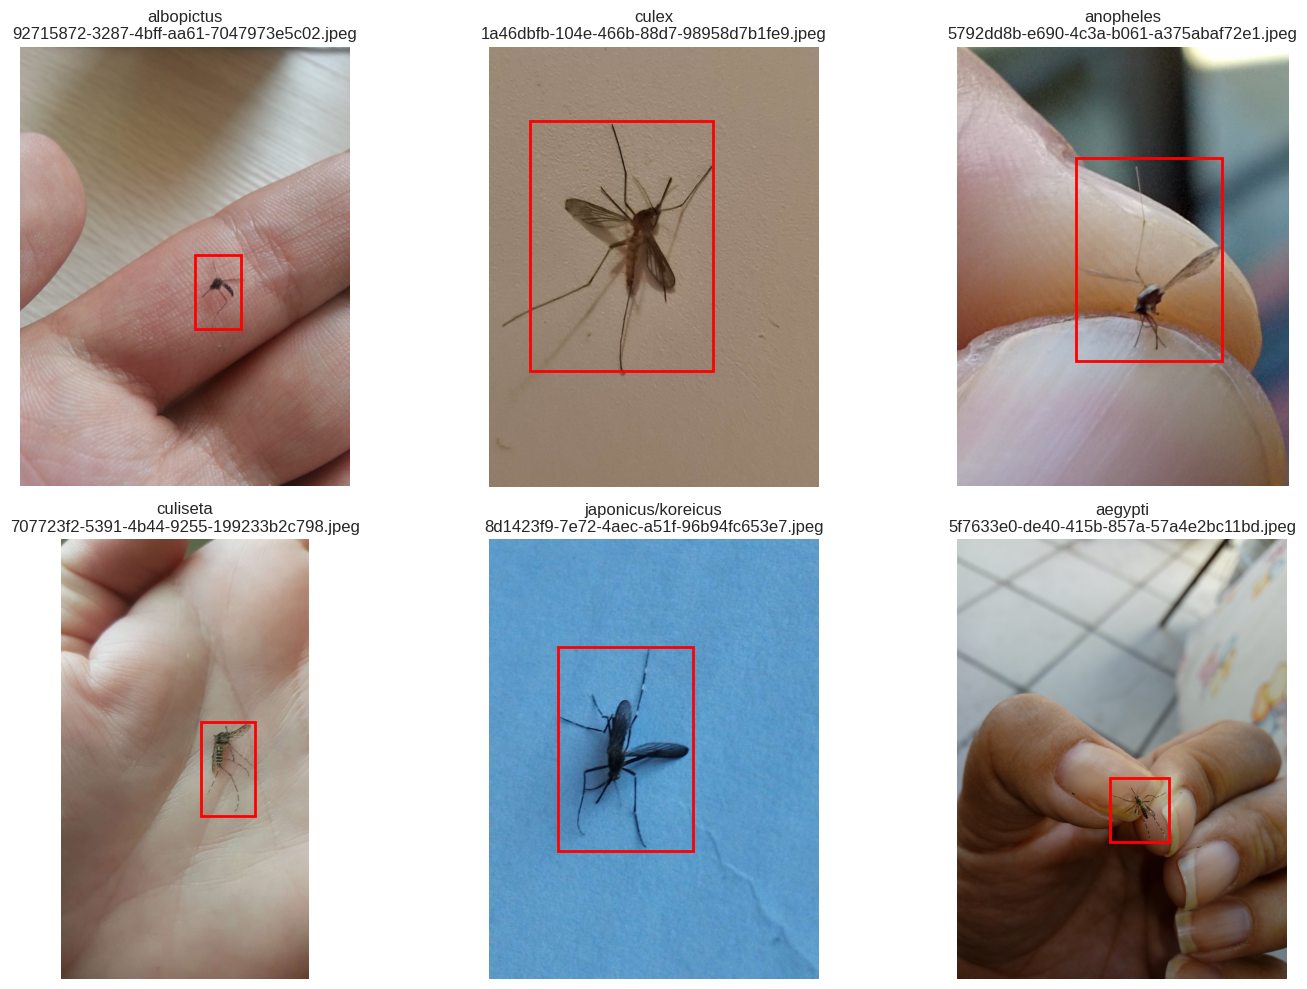

In [ ]:
def display_sample_images(df, num_samples=6):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()
    
    # Utilizar una imagen por cada clase
    classes = df['class_label'].unique()
    
    for i, class_name in enumerate(classes[:num_samples]):
        sample = df[df['class_label'] == class_name].iloc[0]
        
        # Cargar imagen
        img_path = os.path.join(dataset_path, 'train_images', sample['img_fName'])
        
        try:
            img = Image.open(img_path)
            axes[i].imshow(img)
            
            # Dibujar bounding box
            bbox = [sample['bbx_xtl'], sample['bbx_ytl'], sample['bbx_xbr'], sample['bbx_ybr']]
            rect = plt.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], 
                               fill=False, edgecolor='red', linewidth=2)
            axes[i].add_patch(rect)
            
            axes[i].set_title(f'{class_name}\n{sample["img_fName"]}')
            axes[i].axis('off')
            
        except Exception as e:
            axes[i].text(0.5, 0.5, f'Error loading image\n{e}', 
                        ha='center', va='center', transform=axes[i].transAxes)
            axes[i].set_title(f'{class_name} - Error')
            axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

display_sample_images(train_df)

Aquí podemos ver algunos de los ejemplos, dónde podemos observar que las imágenes tienden a tener fondos y tamaños de bounding box relativamente variados. Dentro del análisis exploratorio intentaremos encontrar diferentes patrones o tendencias para tener en mente al implementar un modelo de visión por computadora para realizar predicciones.

### Conjunto de Prueba

**Variables y Tipos de Datos**

In [191]:
print(f"Tipos de datos:\n{test_df.dtypes}")

Tipos de datos:
img_fName    object
img_w         int64
img_h         int64
dtype: object


El dataset de prueba contiene solo la información esencial para realizar inferencias: los nombres de archivo de las imágenes (img_fName) y sus dimensiones (img_w, img_h). La ausencia de bounding boxes y etiquetas de clase confirma que este es un conjunto para predicción pura, donde el modelo deberá detectar y clasificar automáticamente los mosquitos en cada imagen sin supervisión.

**Primeras Entradas**

In [192]:
test_df.head()

,img_fName,img_w,img_h
0,07e0f900-e1d2-4e3c-a812-651a156d7463.jpeg,4032,2268
1,98171e52-0def-4de8-b9ad-23cc3a1f1a2d.jpeg,2448,3264
2,30da361c-282e-4a8c-a714-4de4d5407696.jpeg,2988,5312
3,780ce034-878f-41fc-a23f-5432987ce64a.jpeg,3000,4000
4,6e7e3e96-62a4-46e3-aaa2-ce88f2949f6a.jpeg,4128,3096


**Operaciones de Limpieza**

Al ser el conjunto de prueba, no debemos realizar operaciones de limpieza sobre este conjunto.

### Resumen

**Dataset Entrenamiento:**
- **Tamaño original**: 8,025 imágenes de entrenamiento
- **Tamaño después de limpieza**: 7,966 imágenes de entrenamiento
- **Clases**: 6 especies de mosquitos (albopictus, culex, culiseta, japonicus/koreicus, anopheles, aegypti)
- **Formato**: Imágenes JPEG con anotaciones de bounding boxes

**Dataset Prueba:**
- **Tamaño**: 2,675 imágenes
- **Formato**: Imágenes JPEG

**Problemas identificados y solucionados:**
- **Bounding boxes inválidos**: 5 casos removidos
- **Bounding boxes muy pequeños**: 1 caso removido
- **Bounding boxes muy grandes**: 23 casos identificados y corregidos

## Análisis exploratorio de datos (EDA)

### Descripción de Variables y Observaciones

In [ ]:
cleaned_path = os.path.join(dataset_path, 'train_cleaned.csv')
train_df_clean = pd.read_csv(cleaned_path)

In [ ]:
# Cleaned dataset size
print("=== TRAIN_CLEANED: SHAPE ===")
print(f"Observations: {train_df_clean.shape[0]}")
print(f"Variables: {train_df_clean.shape[1]}")

# Data types
print("\n=== TRAIN_CLEANED: DATA TYPES ===")
print(train_df_clean.dtypes)

# Resume
print("\n=== TRAIN_CLEANED: INFO ===")
print(train_df_clean.info())

=== TRAIN_CLEANED: SHAPE ===
Observations: 8019
Variables: 13

=== TRAIN_CLEANED: DATA TYPES ===
img_fName       object
img_w            int64
img_h            int64
bbx_xtl          int64
bbx_ytl          int64
bbx_xbr          int64
bbx_ybr          int64
class_label     object
bbox_width       int64
bbox_height      int64
bbox_area        int64
image_area       int64
bbox_ratio     float64
dtype: object

=== TRAIN_CLEANED: INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8019 entries, 0 to 8018
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   img_fName    8019 non-null   object 
 1   img_w        8019 non-null   int64  
 2   img_h        8019 non-null   int64  
 3   bbx_xtl      8019 non-null   int64  
 4   bbx_ytl      8019 non-null   int64  
 5   bbx_xbr      8019 non-null   int64  
 6   bbx_ybr      8019 non-null   int64  
 7   class_label  8019 non-null   object 
 8   bbox_width   8019 non-null   

### Resumen de Variables Numéricas

In [ ]:
# Select numeric columns
numeric_cols = train_df_clean.select_dtypes(include=['number']).columns
num_df = train_df_clean[numeric_cols]

# Basic summary (count, mean, std, min, 25%, 50%/median, 75%, max)
desc = num_df.describe().T 


In [ ]:
# Additional dispersion metrics
variance = num_df.var().rename('variance')           
q1 = num_df.quantile(0.25)
q3 = num_df.quantile(0.75)
iqr = (q3 - q1).rename('IQR')                        # interquartile range
cv = (desc['std'] / desc['mean']).rename('CV')       # coefficient of variation
cv = cv.replace([float('inf'), float('-inf')], pd.NA)

# Shape/tailedness
skewness = num_df.skew().rename('skewness')
kurtosis = num_df.kurt().rename('kurtosis')

In [ ]:
# Combine into one table
summary_stats = pd.concat([desc, variance, iqr, cv, skewness, kurtosis], axis=1)

# Reorder columns and round for readability
ordered_cols = ['count', 'mean', 'std', 'variance', 'min', '25%', '50%', '75%', 'max', 'IQR', 'CV', 'skewness', 'kurtosis']
summary_stats = summary_stats[ordered_cols].round(3)

print("=== TRAIN_CLEANED: NUMERIC SUMMARY (central tendency & dispersion) ===")
summary_stats

=== TRAIN_CLEANED: NUMERIC SUMMARY (central tendency & dispersion) ===


,count,mean,std,variance,min,25%,50%,75%,max,IQR,CV,skewness,kurtosis
img_w,8019.0,2043.675,1183.481,1.400627e+06,152.000,1024.000,1846.000,3.024000e+03,9280.0,2.000000e+03,0.579,0.677,0.265
img_h,8019.0,2468.778,1358.392,1.845230e+06,106.000,1095.000,2208.000,4.000000e+03,12000.0,2.905000e+03,0.550,0.390,-0.544
bbx_xtl,8019.0,670.101,523.232,2.737718e+05,0.000,276.000,502.000,9.890000e+02,4971.0,7.130000e+02,0.781,1.327,2.649
bbx_ytl,8019.0,885.068,646.049,4.173788e+05,0.000,390.000,675.000,1.340000e+03,5763.0,9.500000e+02,0.730,0.958,0.839
bbx_xbr,8019.0,1337.473,804.745,6.476145e+05,135.000,639.000,1164.000,1.887500e+03,7327.0,1.248500e+03,0.602,0.887,0.782
bbx_ybr,8019.0,1565.409,905.883,8.206247e+05,98.000,756.500,1333.000,2.305000e+03,7601.0,1.548500e+03,0.579,0.646,-0.167
bbox_width,8019.0,667.372,554.590,3.075706e+05,32.000,290.000,483.000,8.585000e+02,4198.0,5.685000e+02,0.831,1.763,3.429
bbox_height,8019.0,680.341,571.124,3.261822e+05,48.000,292.000,489.000,8.790000e+02,5580.0,5.870000e+02,0.839,1.888,4.580
bbox_area,8019.0,742636.699,1311272.159,1.719435e+12,1824.000,84780.000,232484.000,7.479775e+05,18826920.0,6.631975e+05,1.766,3.653,19.004
image_area,8019.0,6279804.076,5893669.214,3.473534e+13,16112.000,1397760.000,3773952.000,1.200000e+07,108000000.0,1.060224e+07,0.939,2.479,27.972


### Tablas de Frecuencia

In [ ]:
# Identify categorical columns
cat_cols = train_df_clean.select_dtypes(include=['object', 'category']).columns.tolist()

cat_cols = ['class_label'] + [c for c in cat_cols if c != 'class_label']

freq_tables = {} 

In [ ]:
for col in cat_cols:
    total = len(train_df_clean[col])
    
    # Raw counts (including NaN if present)
    counts = train_df_clean[col].value_counts(dropna=False)
    freq = counts.rename('count').to_frame()
    
    # Percentages and cumulative metrics
    freq['percent'] = (freq['count'] / total * 100)
    freq['cum_count'] = freq['count'].cumsum()
    freq['cum_percent'] = freq['percent'].cumsum()
    
    # Round percentages for readability
    freq['percent'] = freq['percent'].round(2)
    freq['cum_percent'] = freq['cum_percent'].round(2)
    
    # Save full table
    freq_tables[col] = freq
    
    # Print a concise preview to avoid massive console output on high-cardinality columns
    unique_vals = train_df_clean[col].nunique(dropna=False)
    print(f"\n=== FREQUENCY TABLE: {col} ===")
    print(f"Unique categories: {unique_vals} | Total rows: {total}")
    
    if unique_vals > 30:
        print("(Preview: top 20 categories by count; the full table is in freq_tables['{col}'])")
        display(freq.head(20))
    else:
        display(freq)


=== FREQUENCY TABLE: class_label ===
Unique categories: 6 | Total rows: 8019


,count,percent,cum_count,cum_percent
class_label,,,,
albopictus,3566,44.47,3566,44.47
culex,3540,44.15,7106,88.61
culiseta,491,6.12,7597,94.74
japonicus/koreicus,321,4.00,7918,98.74
anopheles,63,0.79,7981,99.53
aegypti,38,0.47,8019,100.00



=== FREQUENCY TABLE: img_fName ===
Unique categories: 8019 | Total rows: 8019
(Preview: top 20 categories by count; the full table is in freq_tables['{col}'])


,count,percent,cum_count,cum_percent
img_fName,,,,
92715872-3287-4bff-aa61-7047973e5c02.jpeg,1,0.01,1,0.01
b0f7cc74-2272-4756-a387-38bcaf6965c8.jpeg,1,0.01,2,0.02
82df4b68-0f45-4afe-9215-48488bf3720e.jpeg,1,0.01,3,0.04
331ad30a-7564-4478-b863-7bc760adf5a1.jpeg,1,0.01,4,0.05
1a46dbfb-104e-466b-88d7-98958d7b1fe9.jpeg,1,0.01,5,0.06
46f34803-f754-457d-bdb7-e581d3332e85.jpeg,1,0.01,6,0.07
5792dd8b-e690-4c3a-b061-a375abaf72e1.jpeg,1,0.01,7,0.09
b59baea4-5867-4c79-9f05-c3ba664301e9.jpeg,1,0.01,8,0.10
9637fec0-cf0e-47da-93e7-1ef15af76f27.jpeg,1,0.01,9,0.11


Como tal solo class_label es varibles categórica, la única de este dataset.

### Patrones Clave
Realizar cruces entre variables clave para detectar patrones relevantes.

### Gráficos Exploratorios